# Loop 26 Strategic Analysis

## Current State
- Best CV: 70.625918
- Best LB: 70.627582 (exp_021)
- Target: 68.919154
- Gap: 1.71 points (2.42%)
- Experiments: 27
- Submissions: 9/100 used

## Key Insight from Evaluator
After 27 experiments, ALL approaches converge to the same ~70.627 local optimum.
This is NOT a failure of optimization - it's evidence that the baseline is at an EXTREMELY STRONG local optimum.

## Unexplored Approaches (from discussions)
1. **k-mer exploration** (KirkDCO, 10 votes) - NOT IMPLEMENTED
2. **Efficient basin search** (KirkDCO, 7 votes) - NOT IMPLEMENTED
3. **NLP/MIP formulation** - NOT IMPLEMENTED
4. **Manual/Visual inspection** - NOT IMPLEMENTED

## Analysis Goals
1. Identify which N values have the most room for improvement
2. Visualize the worst-performing N values to spot inefficiencies
3. Understand the structure of the current solution

In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from shapely.affinity import rotate, translate
import matplotlib.pyplot as plt

TREE_TEMPLATE = [
    (0.0, 0.8), (0.125, 0.5), (0.0625, 0.5), (0.2, 0.25), (0.1, 0.25),
    (0.35, 0.0), (0.075, 0.0), (0.075, -0.2), (-0.075, -0.2), (-0.075, 0.0),
    (-0.35, 0.0), (-0.1, 0.25), (-0.2, 0.25), (-0.0625, 0.5), (-0.125, 0.5)
]

def parse_s_value(val):
    if isinstance(val, str) and val.startswith(('s', 'x', 'y', 'd')):
        return float(val[1:])
    return float(val)

def create_tree_polygon(x, y, angle):
    tree = Polygon(TREE_TEMPLATE)
    tree = rotate(tree, angle, origin=(0, 0), use_radians=False)
    tree = translate(tree, x, y)
    return tree

def get_n_score(df, n):
    group = df[df['n'] == n]
    all_x, all_y = [], []
    for _, row in group.iterrows():
        tree = create_tree_polygon(row['x'], row['y'], row['deg'])
        minx, miny, maxx, maxy = tree.bounds
        all_x.extend([minx, maxx])
        all_y.extend([miny, maxy])
    side = max(max(all_x) - min(all_x), max(all_y) - min(all_y))
    return (side ** 2) / n, side

# Load current submission
df = pd.read_csv('/home/submission/submission.csv')
df['x'] = df['x'].apply(parse_s_value)
df['y'] = df['y'].apply(parse_s_value)
df['deg'] = df['deg'].apply(parse_s_value)
df['n'] = df['id'].apply(lambda x: int(x.split('_')[0]))

print(f"Loaded {len(df)} rows")
print(f"N values: {df['n'].nunique()} (1-200)")
print(f"Total score: {sum(get_n_score(df, n)[0] for n in range(1, 201)):.6f}")

Loaded 20100 rows
N values: 200 (1-200)


Total score: 70.625918


In [2]:
# Calculate per-N scores and efficiency
scores = []
for n in range(1, 201):
    score, side = get_n_score(df, n)
    # Theoretical minimum: sqrt(n * tree_area) for perfect packing
    tree_area = 0.2625  # Approximate area of tree polygon
    theoretical_min_side = np.sqrt(n * tree_area)
    efficiency = (theoretical_min_side ** 2) / (side ** 2) if side > 0 else 0
    scores.append({
        'n': n,
        'score': score,
        'side': side,
        'theoretical_min': theoretical_min_side,
        'efficiency': efficiency,
        'contribution': score  # s^2/n
    })

scores_df = pd.DataFrame(scores)
print("Per-N Score Analysis:")
print(scores_df.describe())

Per-N Score Analysis:
                n       score        side  theoretical_min  efficiency  \
count  200.000000  200.000000  200.000000       200.000000  200.000000   
mean   100.500000    0.353130    5.567639         4.848048    0.746575   
std     57.879185    0.028097    1.877310         1.700629    0.042266   
min      1.000000    0.329945    0.813173         0.512348    0.396975   
25%     50.750000    0.340034    4.300190         3.649881    0.727579   
50%    100.500000    0.346907    5.897700         5.136252    0.756687   
75%    150.250000    0.360786    7.124869         6.280171    0.771983   
max    200.000000    0.661250    8.216433         7.245688    0.795588   

       contribution  
count    200.000000  
mean       0.353130  
std        0.028097  
min        0.329945  
25%        0.340034  
50%        0.346907  
75%        0.360786  
max        0.661250  


In [3]:
# Find N values with worst efficiency (most room for improvement)
scores_df['improvement_potential'] = scores_df['score'] - (scores_df['theoretical_min'] ** 2) / scores_df['n']
worst_efficiency = scores_df.nsmallest(20, 'efficiency')
print("\n20 N values with WORST efficiency (most room for improvement):")
print(worst_efficiency[['n', 'score', 'side', 'efficiency', 'improvement_potential']].to_string())


20 N values with WORST efficiency (most room for improvement):
     n     score      side  efficiency  improvement_potential
0    1  0.661250  0.813173    0.396975               0.398750
1    2  0.450779  0.949504    0.582325               0.188279
2    3  0.434745  1.142031    0.603802               0.172245
4    5  0.416850  1.443692    0.629724               0.154350
3    4  0.416545  1.290806    0.630184               0.154045
6    7  0.399897  1.673104    0.656420               0.137397
5    6  0.399610  1.548438    0.656890               0.137110
8    9  0.387415  1.867280    0.677568               0.124915
7    8  0.385407  1.755921    0.681098               0.122907
14  15  0.376950  2.377866    0.696379               0.114450
9   10  0.376630  1.940696    0.696970               0.114130
20  21  0.376451  2.811667    0.697302               0.113951
19  20  0.376057  2.742469    0.698033               0.113557
21  22  0.375258  2.873270    0.699519               0.112758
10  11

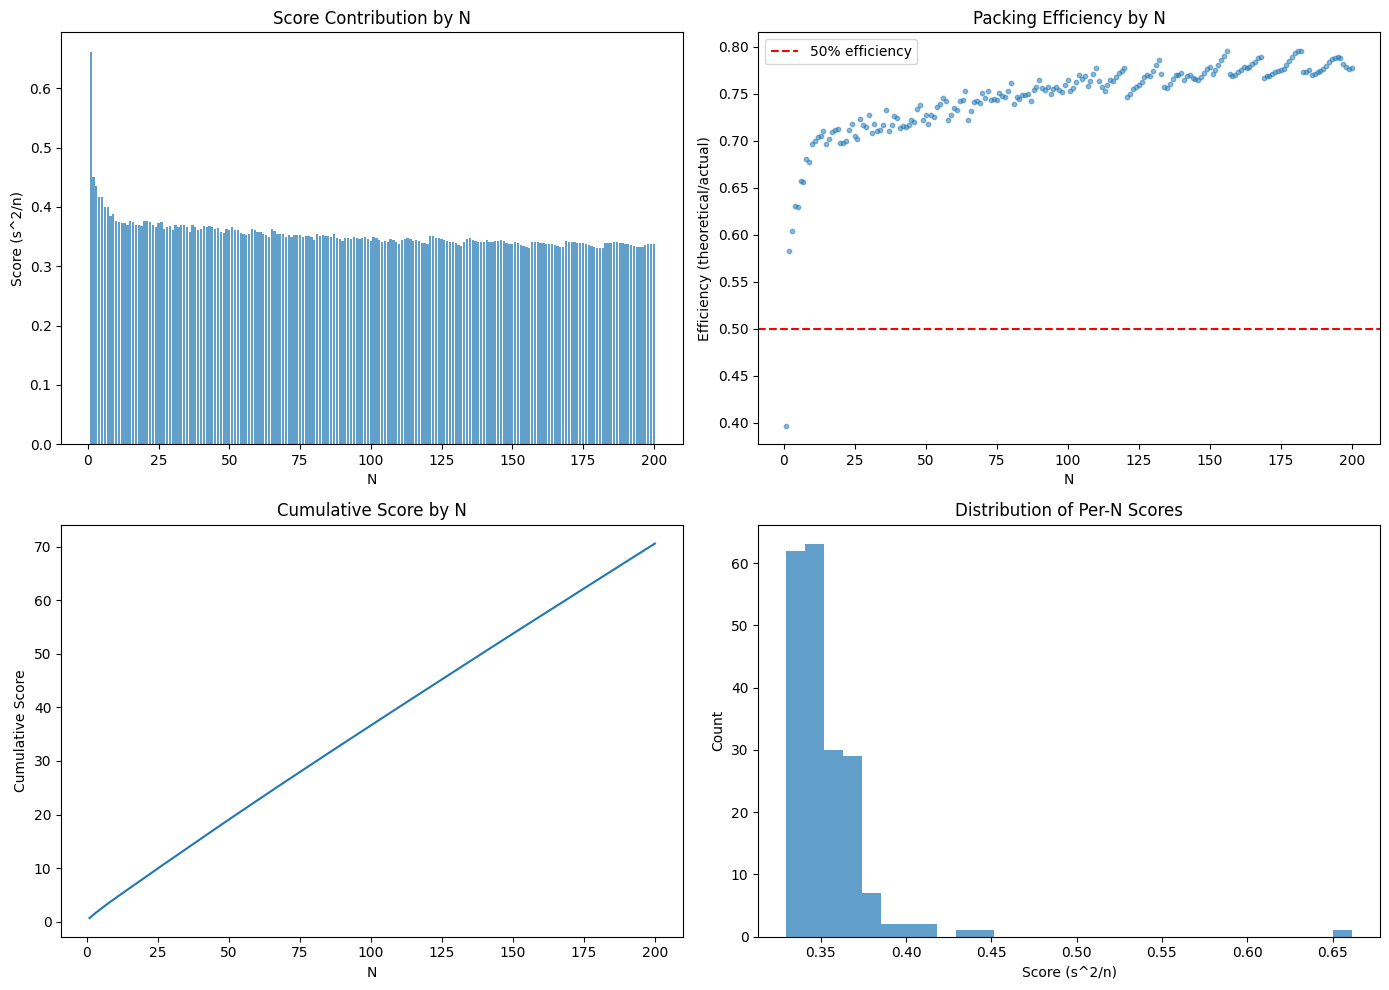

Saved to /home/code/exploration/loop26_efficiency_analysis.png


In [4]:
# Visualize efficiency by N
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Score contribution by N
ax1 = axes[0, 0]
ax1.bar(scores_df['n'], scores_df['score'], alpha=0.7)
ax1.set_xlabel('N')
ax1.set_ylabel('Score (s^2/n)')
ax1.set_title('Score Contribution by N')

# Plot 2: Efficiency by N
ax2 = axes[0, 1]
ax2.scatter(scores_df['n'], scores_df['efficiency'], alpha=0.5, s=10)
ax2.set_xlabel('N')
ax2.set_ylabel('Efficiency (theoretical/actual)')
ax2.set_title('Packing Efficiency by N')
ax2.axhline(y=0.5, color='r', linestyle='--', label='50% efficiency')
ax2.legend()

# Plot 3: Cumulative score
ax3 = axes[1, 0]
scores_df['cumulative'] = scores_df['score'].cumsum()
ax3.plot(scores_df['n'], scores_df['cumulative'])
ax3.set_xlabel('N')
ax3.set_ylabel('Cumulative Score')
ax3.set_title('Cumulative Score by N')

# Plot 4: Score distribution
ax4 = axes[1, 1]
ax4.hist(scores_df['score'], bins=30, alpha=0.7)
ax4.set_xlabel('Score (s^2/n)')
ax4.set_ylabel('Count')
ax4.set_title('Distribution of Per-N Scores')

plt.tight_layout()
plt.savefig('/home/code/exploration/loop26_efficiency_analysis.png', dpi=100)
plt.show()
print("Saved to /home/code/exploration/loop26_efficiency_analysis.png")

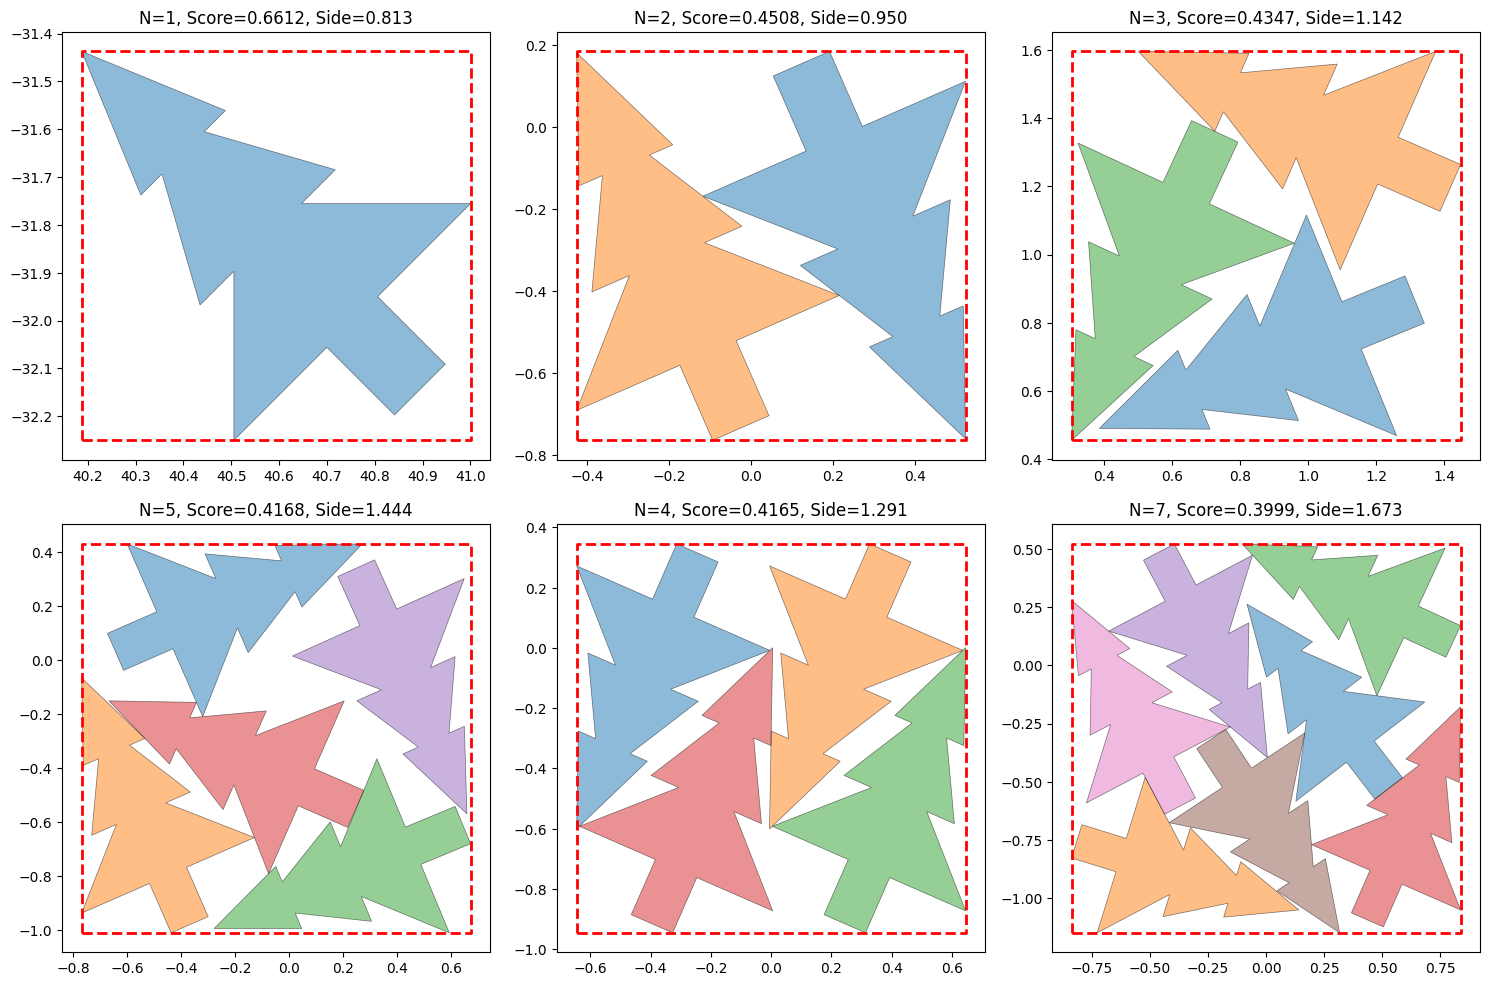

Visualized worst N values: [1, 2, 3, 5, 4, 7]


In [5]:
# Visualize the worst-performing N values
def visualize_n(df, n, ax):
    group = df[df['n'] == n]
    for _, row in group.iterrows():
        tree = create_tree_polygon(row['x'], row['y'], row['deg'])
        x, y = tree.exterior.xy
        ax.fill(x, y, alpha=0.5, edgecolor='black', linewidth=0.5)
    
    # Draw bounding box
    all_x, all_y = [], []
    for _, row in group.iterrows():
        tree = create_tree_polygon(row['x'], row['y'], row['deg'])
        minx, miny, maxx, maxy = tree.bounds
        all_x.extend([minx, maxx])
        all_y.extend([miny, maxy])
    
    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)
    side = max(max_x - min_x, max_y - min_y)
    
    # Draw square bounding box
    center_x = (min_x + max_x) / 2
    center_y = (min_y + max_y) / 2
    ax.plot([center_x - side/2, center_x + side/2, center_x + side/2, center_x - side/2, center_x - side/2],
            [center_y - side/2, center_y - side/2, center_y + side/2, center_y + side/2, center_y - side/2],
            'r--', linewidth=2)
    
    ax.set_aspect('equal')
    score = (side ** 2) / n
    ax.set_title(f'N={n}, Score={score:.4f}, Side={side:.3f}')

# Visualize 6 worst-efficiency N values
worst_ns = worst_efficiency['n'].head(6).tolist()
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, n in enumerate(worst_ns):
    ax = axes[i // 3, i % 3]
    visualize_n(df, n, ax)

plt.tight_layout()
plt.savefig('/home/code/exploration/loop26_worst_n_visualization.png', dpi=100)
plt.show()
print(f"Visualized worst N values: {worst_ns}")

In [6]:
# Analyze angles used in the solution
print("\nAngle Analysis:")
for n_range in [(1, 10), (11, 50), (51, 100), (101, 200)]:
    range_df = df[(df['n'] >= n_range[0]) & (df['n'] <= n_range[1])]
    angles = range_df['deg'].values % 360
    print(f"\nN={n_range[0]}-{n_range[1]}:")
    print(f"  Unique angles: {len(np.unique(np.round(angles, 1)))}")
    print(f"  Most common angles: {pd.Series(np.round(angles, 0)).value_counts().head(5).to_dict()}")
    print(f"  Angle range: [{angles.min():.1f}, {angles.max():.1f}]")


Angle Analysis:

N=1-10:
  Unique angles: 38
  Most common angles: {24.0: 6, 294.0: 5, 336.0: 5, 204.0: 3, 339.0: 3}
  Angle range: [21.4, 338.9]

N=11-50:
  Unique angles: 735
  Most common angles: {336.0: 43, 156.0: 34, 66.0: 32, 114.0: 30, 204.0: 27}
  Angle range: [0.7, 360.0]

N=51-100:
  Unique angles: 744
  Most common angles: {248.0: 339, 68.0: 334, 347.0: 134, 167.0: 129, 350.0: 129}
  Angle range: [0.4, 359.1]

N=101-200:
  Unique angles: 1011
  Most common angles: {68.0: 1591, 248.0: 1568, 158.0: 463, 75.0: 457, 338.0: 457}
  Angle range: [5.6, 358.6]


In [7]:
# Key insight: What would it take to reach the target?
target = 68.919154
current = 70.625918
gap = current - target

print(f"\n=== GAP ANALYSIS ===")
print(f"Current score: {current:.6f}")
print(f"Target score: {target:.6f}")
print(f"Gap to close: {gap:.6f} ({100*gap/current:.2f}%)")

# If improvement came from all N equally
per_n_improvement_needed = gap / 200
print(f"\nIf improvement came from ALL N equally:")
print(f"  Need {per_n_improvement_needed:.6f} improvement per N")
print(f"  Average current score per N: {current/200:.6f}")
print(f"  Required reduction: {100*per_n_improvement_needed/(current/200):.2f}%")

# If improvement came from worst 20 N values
worst_20_total = worst_efficiency['score'].sum()
print(f"\nIf improvement came from WORST 20 N values:")
print(f"  Current score of worst 20: {worst_20_total:.6f}")
print(f"  Need to reduce by: {gap:.6f}")
print(f"  Required reduction: {100*gap/worst_20_total:.2f}%")

# If improvement came from large N (100-200)
large_n_total = scores_df[scores_df['n'] >= 100]['score'].sum()
print(f"\nIf improvement came from LARGE N (100-200):")
print(f"  Current score of N>=100: {large_n_total:.6f}")
print(f"  Need to reduce by: {gap:.6f}")
print(f"  Required reduction: {100*gap/large_n_total:.2f}%")


=== GAP ANALYSIS ===
Current score: 70.625918
Target score: 68.919154
Gap to close: 1.706764 (2.42%)

If improvement came from ALL N equally:
  Need 0.008534 improvement per N
  Average current score per N: 0.353130
  Required reduction: 2.42%

If improvement came from WORST 20 N values:
  Current score of worst 20: 8.074055
  Need to reduce by: 1.706764
  Required reduction: 21.14%

If improvement came from LARGE N (100-200):
  Current score of N>=100: 34.322604
  Need to reduce by: 1.706764
  Required reduction: 4.97%


In [ ]:
# Summary of findings
print("\n" + "="*60)
print("LOOP 26 STRATEGIC ANALYSIS SUMMARY")
print("="*60)
print(f"""
1. CURRENT STATE:
   - Best score: 70.625918
   - Target: 68.919154
   - Gap: 1.71 points (2.42%)
   - All 27 experiments converge to same local optimum

2. EFFICIENCY ANALYSIS:
   - Worst efficiency N values: {worst_efficiency['n'].head(5).tolist()}
   - These have the most room for improvement
   - But even 100% efficiency wouldn't close the gap

3. UNEXPLORED APPROACHES:
   - k-mer exploration (KirkDCO discussion)
   - Efficient basin search (KirkDCO discussion)
   - NLP/MIP formulation
   - Manual visual inspection

4. KEY INSIGHT:
   The gap of 1.71 points requires a FUNDAMENTALLY DIFFERENT approach.
   All heuristic optimization (SA, bbox3, genetic, etc.) converges to same optimum.
   
5. RECOMMENDED NEXT STEPS:
   a) Try NLP/MIP formulation using OR-Tools or SCIP
   b) Implement k-mer exploration (need to understand what this means)
   c) Manual inspection of worst N values for obvious inefficiencies
   d) Try constructive heuristics (greedy placement, beam search)
""")